**Importing Libraries**

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer # For Normalization
from sklearn.preprocessing import StandardScaler # For Standardization
from tensorflow.keras.utils import to_categorical # For One-Hot Encoding
from sklearn.decomposition import PCA

**Loading Data Set CIFAR 10 & Splitting it in train-test set**

In [44]:
# loading cifar10 dataset
cifar10 = tf.keras.datasets.cifar10
(X, y), (X_test, y_test) = cifar10.load_data() # load cifar10

# combine train and test dataset
X_full = np.concatenate((X, X_test), axis=0)
y_full = np.concatenate((y, y_test), axis=0)

# select a random subset
subset_size = 10000
indices = np.random.choice(len(X_full), size=subset_size, replace=False)
X_full = X_full[indices]
y_full = y_full[indices]

# Split data into train-validation-test sets (60%-30%-10%)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.4,
                                                    random_state=0)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                random_state=0)

**Visualizing dataset samples**

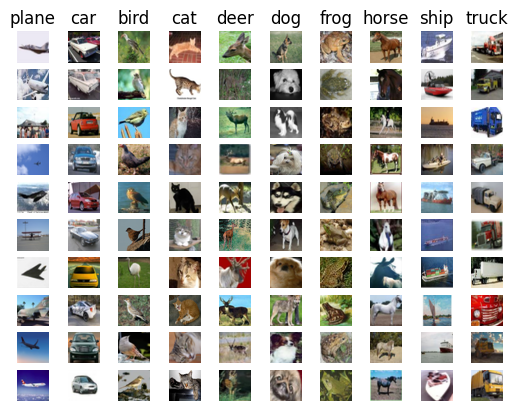

In [45]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

**Data Preprocessing**

In [46]:
# Reshaping Data into vectors
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print("X_train.shape: {}\ny_train.shape: {}\nX_test.shape: {}\ny_test.shape: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train.shape: (6000, 3072)
y_train.shape: (6000, 1)
X_test.shape: (2000, 3072)
y_test.shape: (2000, 1)


In [47]:
# Standardization of data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

np.min(X_train), np.max(X_train)


(-2.2106465224212886, 2.633731943280292)

In [48]:
# pca for dimensionality reduction
pca_cifar = PCA(n_components=200)
X_train = pca_cifar.fit_transform(X_train)
X_val = pca_cifar.transform(X_val)
X_test = pca_cifar.transform(X_test)

print("X_train.shape: {}\ny_train.shape: {}\nX_test.shape: {}\ny_test.shape: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train.shape: (6000, 200)
y_train.shape: (6000, 1)
X_test.shape: (2000, 200)
y_test.shape: (2000, 1)


**Nearest Class Centroid (NCC)**

Κάνω Cross-Validation για 2 diaforetika cv=5 και cv=10 και βλέπω ότι τα αποτελέματα είναι τα ίδια σε ότι αφορά στην ακρίβεια των train-validation-test sets.

In [49]:
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

ncc_model = NearestCentroid()

param_grid = {
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(ncc_model, param_grid, cv=5, n_jobs=-1)  # cv=5 για 5-fold cross-validation

grid_search.fit(X_train, y_train)

best_model_ncc = grid_search.best_estimator_
print("Best Model Parameters:", grid_search.best_params_)
print("Best Model Accuracy (CV):", grid_search.best_score_)

Best Model Parameters: {'metric': 'manhattan'}
Best Model Accuracy (CV): 0.28233333333333327


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [50]:
# Train set Accuracy
y_train_pred = best_model_ncc.predict(X_train)
train_accuracy = accuracy_score(y_train.ravel(), y_train_pred)
print("Train Set Accuracy:", train_accuracy)

# Validation set Accuracy
y_val_pred = best_model_ncc.predict(X_val)
val_accuracy = accuracy_score(y_val.ravel(), y_val_pred)
print("Validation Set Accuracy:", val_accuracy)

# Test set Accuracy
y_test_pred = best_model_ncc.predict(X_test)
test_accuracy = accuracy_score(y_test.ravel(), y_test_pred)
print("Test Set Accuracy:", test_accuracy)

Train Set Accuracy: 0.30216666666666664
Validation Set Accuracy: 0.2895
Test Set Accuracy: 0.2885


Plot correct & incorrect prediction

In [51]:
import pandas as pd

ncc_pred = best_model_ncc.predict(X_test)
ncc_results = ncc_pred[:20].ravel()
yTest_results = y_test[:20].ravel()

# DataFrame with predicted and actual values
results_df = pd.DataFrame({
    'Prediction': ncc_results,
    'Actual Value': yTest_results
})

# print the dataframe
print(results_df)

    Prediction  Actual Value
0            0             0
1            9             8
2            8             8
3            5             4
4            7             4
5            9             7
6            0             8
7            9             9
8            4             6
9            6             4
10           8             7
11           4             3
12           7             7
13           8             8
14           9             9
15           6             4
16           8             8
17           0             2
18           6             6
19           6             6


In [52]:
# Create lists for correct and incorrect predictions
correct_predictions = []
incorrect_predictions = []

for i in range(len(ncc_results)):
    if ncc_results[i] == yTest_results[i]:
        correct_predictions.append(i)
    else:
        incorrect_predictions.append(i)

print("Correct Predictions:", correct_predictions)
print("Incorrect Predictions:", incorrect_predictions)

Correct Predictions: [0, 2, 7, 12, 13, 14, 16, 18, 19]
Incorrect Predictions: [1, 3, 4, 5, 6, 8, 9, 10, 11, 15, 17]


In [53]:
# Data reconstruction
X_test_reconstructed = pca_cifar.inverse_transform(X_test)

X_test_reconstructed = np.clip(X_test_reconstructed, 0, 1)
X_test_reconstructed = X_test_reconstructed.astype(np.float32)

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Class names
classesName = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Image preparation
def plt_img(x):
    nrow = 32
    ncol = 32
    ncolors = 3
    xsq = x.reshape((nrow, ncol, ncolors))
    plt.imshow(xsq)

# Number of images to plot (2 correct & 2 incorrect)
nplt = 2

# Plot correct predictions
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<ipython-input-55-62fcde5e35d0>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = classesName[int(y_test[ind])]  # actual label


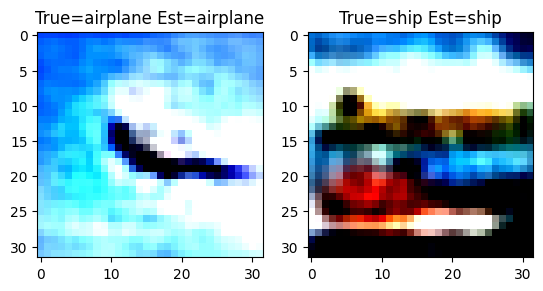

In [55]:
# Plot correct predictions
for i in range(nplt):
   plt.subplot(1, nplt, i + 1)
   ind = correct_predictions[i]  # select the correct sample
   plt_img(X_test_reconstructed[ind, :])  # use of reconstructed data for plotting

   # Actual and Predicted label
   true_label = classesName[int(y_test[ind])]  # actual label
   est_label = classesName[int(ncc_pred[ind])]  # predicted label

   # Τίτλος εικόνας
   plt.title(f'True={true_label} Est={est_label}')

<ipython-input-56-b8b80da65950>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = classesName[int(y_test[ind])]  # actual label


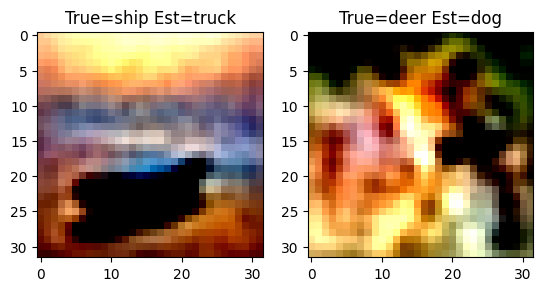

In [56]:
# Plot incorrect predictions
for i in range(nplt):
    plt.subplot(1, nplt, i + 1)
    ind = incorrect_predictions[i] # select the incorrect sample
    plt_img(X_test_reconstructed[ind, :]) # use of reconstructed data for plotting

    # Actual and Predicted label
    true_label = classesName[int(y_test[ind])]  # actual label
    est_label = classesName[int(ncc_pred[ind])]  # predicted label

    # Τίτλος εικόνας
    plt.title(f'True={true_label} Est={est_label}')